# Code

In [2]:
from commonfunctions import *
from skimage.exposure import histogram
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.morphology import binary_opening, binary_erosion, binary_closing
from ArabicOcr import arabicocr
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def movePointBy90(hieght, width, i, j):
    iNew = -j + width - 1
    jNew = i
    return int(iNew), int(jNew)

def rotateMatrix90(mat):
    image2 = np.zeros([mat.shape[1], mat.shape[0]])
    for i in range(mat.shape[0]-1):
        for j in range(mat.shape[1]-1):
            newPoint = movePointBy90(mat.shape[0], mat.shape[1], i, j)
            image2[newPoint[0], newPoint[1]]=mat[i,j]
    return image2
def rotateMatrixNTimes(mat, n=1):
    for i in range(0, n):
        mat = rotateMatrix90(mat)
    return mat

def get_chars(img):
    contours = find_contours(img, 0.8)
    with_boxes  = np.zeros(img.shape, dtype=float)
    bounding_boxes = []

    for contour in contours:
        Xmin = int(np.min(contour[:,1]))
        Xmax = int(np.max(contour[:,1]))
        Ymin = int(np.min(contour[:,0]))
        Ymax = int(np.max(contour[:,0]))
        bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])

    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        if(abs(Xmax-Xmin)/abs(Ymax-Ymin) >= 0.1 and abs(Xmax-Xmin)/abs(Ymax-Ymin) <= 1.9 and abs(Ymax-Ymin) > 12):
            rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=with_boxes.shape)
            with_boxes[rr, cc] = 1 #set color black
            char = img[rr,cc]
            char = rotateMatrixNTimes(char, 3)
            char = np.fliplr(char)
            show_images([char], ["Char"])


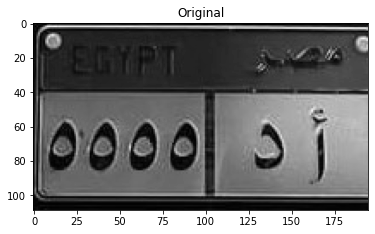

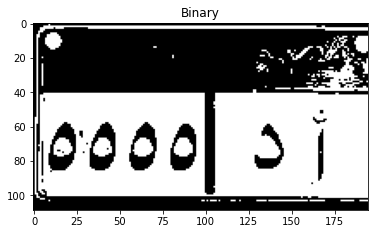

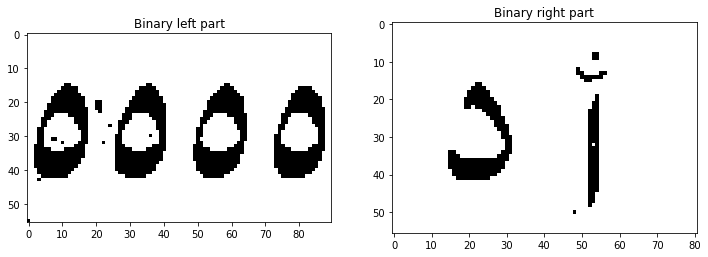

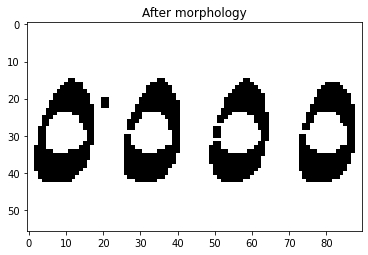

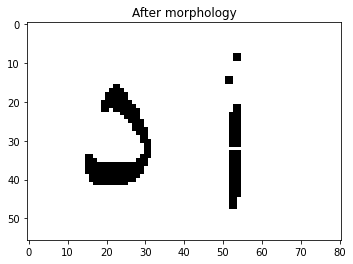

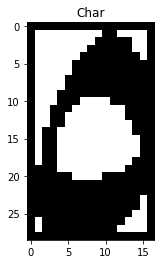

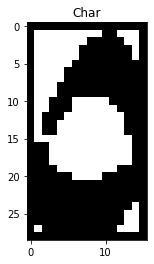

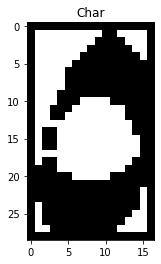

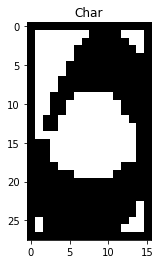

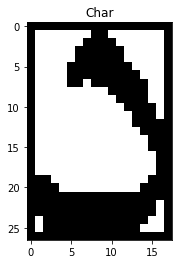

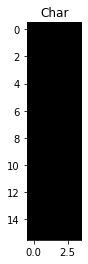

NameError: name 'with_boxes' is not defined

In [4]:
image = (rgb2gray(io.imread("img.jpg")) * 255).astype("uint8")
show_images([image], ["Original"])
image = image > 70
show_images([image], ["Binary"])
x,y = image.shape
rightPart = image[int(x//2.5):x-int(x//10),int(y//1.7):y]
leftPart = image[int(x//2.5):x-int(x//10),int(y//25):int(y//2)]
show_images([leftPart, rightPart], ["Binary left part", "Binary right part"])

structuringEl = np.ones((2, 2))        
leftPart = binary_closing(leftPart, structuringEl)
rightPart = binary_closing(rightPart, structuringEl)
show_images([leftPart], ["After morphology"])
show_images([rightPart], ["After morphology"])
get_chars(leftPart)
get_chars(rightPart)

show_images([leftPart, with_boxes], ["Before boxes", "With only objects"])
